# Analyse de données

# Prédiction des résultats de match football de ligue 1 


## Pré-processing des datasets

### Importations des librairies nécessaires pour la suite du projet

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

### Chargement des datasets

In [90]:
clubs_fr=pd.read_csv("clubs_fr.csv")
game_events=pd.read_csv("game_events.csv")
match_2023_to_predict=pd.read_csv("match_2023.csv")
matchs_2013_2022=pd.read_csv("matchs_2013_2022.csv")
player_appearance=pd.read_csv("player_appearance.csv")
player_valuation_before_season=pd.read_csv("player_valuation_before_season.csv")
game_lineups=pd.read_csv("game_lineups.csv")

C:\Users\phpor\AppData\Local\Temp\ipykernel_20800\1168608779.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  game_lineups=pd.read_csv("game_lineups.csv")


### Réglages des problèmes sur le type des valeurs de certaines colonnes

In [92]:
match_2023_to_predict["season"]=2023 # Crée une colonne pour indiquer la saison des matchs (permettra de merge durant le pre-processing)

    #print(game_lineups.isna().sum())

# Voir les valeurs uniques de la colonne 10
    #print(game_lineups.iloc[:, 9].unique())

game_lineups["number"] = game_lineups["number"].replace("-", 0)  # Remplace les `-` par 0
game_lineups["number"] = game_lineups["number"].fillna(0).astype(int)# Remplace les NaN par 0 et force la conversion en int

# Vérifier le type final
    #print(game_lineups.dtypes)

# On concatène les dataframes pour enrichir au maximum l'ensemble des matchs d'informations pertinentes
df_all_matches=pd.concat([matchs_2013_2022,match_2023_to_predict],ignore_index=True) 

### Visualisation de l'importance du feature de jouer à domicile ou non 

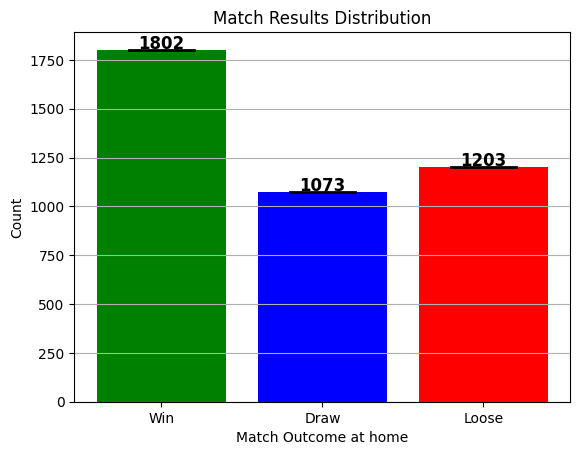

Victoires à domicile : 44.19%
Victoires à l'extérieur : 29.50%
Matchs nuls : 26.31%


In [96]:
total_matches = len(matchs_2013_2022)

# Calcul du nombre de victoires, nuls et défaites
win = len(matchs_2013_2022[matchs_2013_2022.results == 1])
draw = len(matchs_2013_2022[matchs_2013_2022.results == 0])
loose = len(matchs_2013_2022[matchs_2013_2022.results == -1])

home_win_rate = (win / total_matches) * 100
away_win_rate = (loose / total_matches) * 100
draw_rate = (draw / total_matches) * 100

# Création du graphique en barres
labels = ["Win", "Draw", "Loose"]
values = [win, draw, loose]

plt.bar(labels, values, color=["green", "blue", "red"])
# Ajouter les valeurs au-dessus des barres avec un petit trait
for i, v in enumerate(values):
    plt.text(i, v + 5, str(v), ha="center", fontsize=12, fontweight="bold")  # Texte
    plt.plot([i - 0.2, i + 0.2], [v, v], color="black", linewidth=2)  # Petit trait

plt.xlabel("Match Outcome at home")
plt.ylabel("Count")
plt.title("Match Results Distribution")
plt.grid(axis="y")
plt.show()

print(f"Victoires à domicile : {home_win_rate:.2f}%")
print(f"Victoires à l'extérieur : {away_win_rate:.2f}%")
print(f"Matchs nuls : {draw_rate:.2f}%")

### Enrichissement du dataframe général pour avoir la valeur des équipes pour chaque matchs ainsi que 2 features sur le ratio et la diff entre 2 équipes s'affrontant

In [99]:
# Filtrer uniquement les joueurs de Ligue 1 (FR1)
player_valuation_before_season = player_valuation_before_season[player_valuation_before_season["player_club_domestic_competition_id"] == "FR1"]
player_valuation_before_season["date"] = pd.to_datetime(player_valuation_before_season["date"])
player_valuation_before_season["season"] = player_valuation_before_season["date"].dt.year.where(player_valuation_before_season["date"].dt.month < 7, player_valuation_before_season["date"].dt.year + 1)


# Calculer la valeur marchande totale par club et saison
df_team_value = player_valuation_before_season.groupby(["current_club_id", "season"])["market_value_in_eur"].sum().reset_index()
df_team_value.rename(columns={"current_club_id": "club_id", "market_value_in_eur": "team_value"}, inplace=True)

# Joindre ces valeurs aux matchs pour obtenir home_team_value et away_team_value
df_all_matches = df_all_matches.merge(df_team_value, left_on=["home_club_id", "season"], right_on=["club_id", "season"], how="left")
df_all_matches.rename(columns={"team_value": "home_team_value"}, inplace=True)
df_all_matches.drop(columns=["club_id"], inplace=True)  # On n'a plus besoin de cette colonne temporaire

df_all_matches = df_all_matches.merge(df_team_value, left_on=["away_club_id", "season"], right_on=["club_id", "season"], how="left")
df_all_matches.rename(columns={"team_value": "away_team_value"}, inplace=True)
df_all_matches.drop(columns=["club_id"], inplace=True)  # On n'a plus besoin de cette colonne temporaire

# Suppression automatique des doublons en gardant la première version
df_all_matches = df_all_matches.loc[:, ~df_all_matches.columns.duplicated()]


df_all_matches["value_diff"] = (df_all_matches["home_team_value"].fillna(0).astype(float) 
                               - df_all_matches["away_team_value"].fillna(0).astype(float))
df_all_matches["value_diff_ratio"] = (df_all_matches["home_team_value"].fillna(0).astype(float) 
                               / df_all_matches["away_team_value"].fillna(0).astype(float))

### Visualisation du feature de la valeur monétaire de chaque équipe 

['2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021'
 '2022']


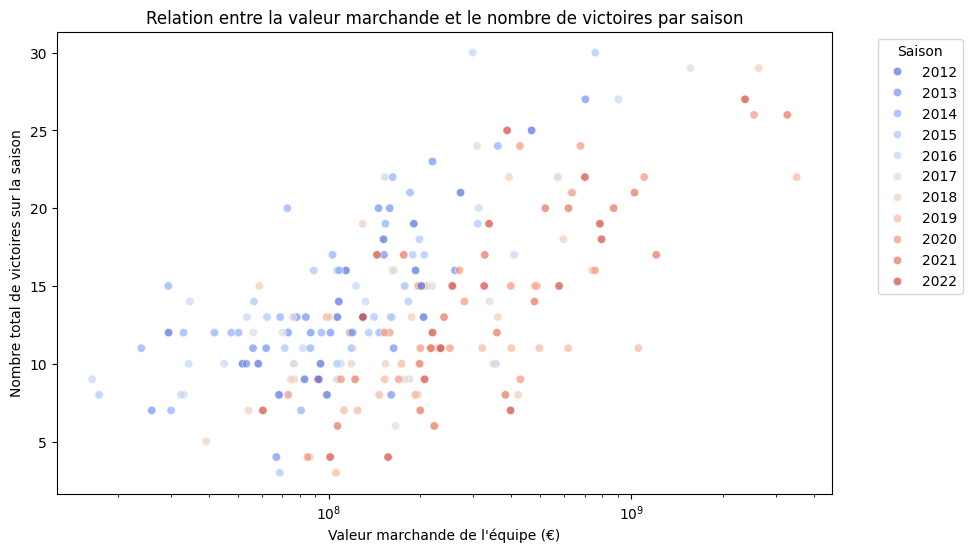

In [102]:

# Calculer le nombre de victoires par équipe et par saison
df_wins = df_all_matches[df_all_matches["results"] == 1].groupby(["home_club_id", "season"]).size().reset_index(name="home_wins")
df_wins_away = df_all_matches[df_all_matches["results"] == -1].groupby(["away_club_id", "season"]).size().reset_index(name="away_wins")

# Fusionner home et away wins
df_wins = df_wins.merge(df_wins_away, left_on=["home_club_id", "season"], right_on=["away_club_id", "season"], how="outer").fillna(0)
df_wins["total_wins"] = df_wins["home_wins"] + df_wins["away_wins"]
df_wins = df_wins.rename(columns={"home_club_id": "club_id"}).drop(columns=["away_club_id"])

# Ajouter la valeur marchande de chaque club avant la saison
df_wins = df_wins.merge(df_team_value, on=["club_id", "season"], how="left")
df_wins["season"] = df_wins["season"].astype(str)  # Convertir en string pour que seaborn gère bien la légende

# Visualisation
plt.figure(figsize=(10, 6))
print(df_wins["season"].unique())  # Vérifier les valeurs uniques

sns.scatterplot(data=df_wins, x="team_value", y="total_wins", hue="season", palette="coolwarm", alpha=0.7)
plt.title("Relation entre la valeur marchande et le nombre de victoires par saison")
plt.xlabel("Valeur marchande de l'équipe (€)")
plt.ylabel("Nombre total de victoires sur la saison")
plt.legend(title="Saison", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xscale("log")  # Pour une meilleure répartition
plt.show()

### Feature permettant d'avoir la diffèrence de place au classement général au moment où le match a lieu

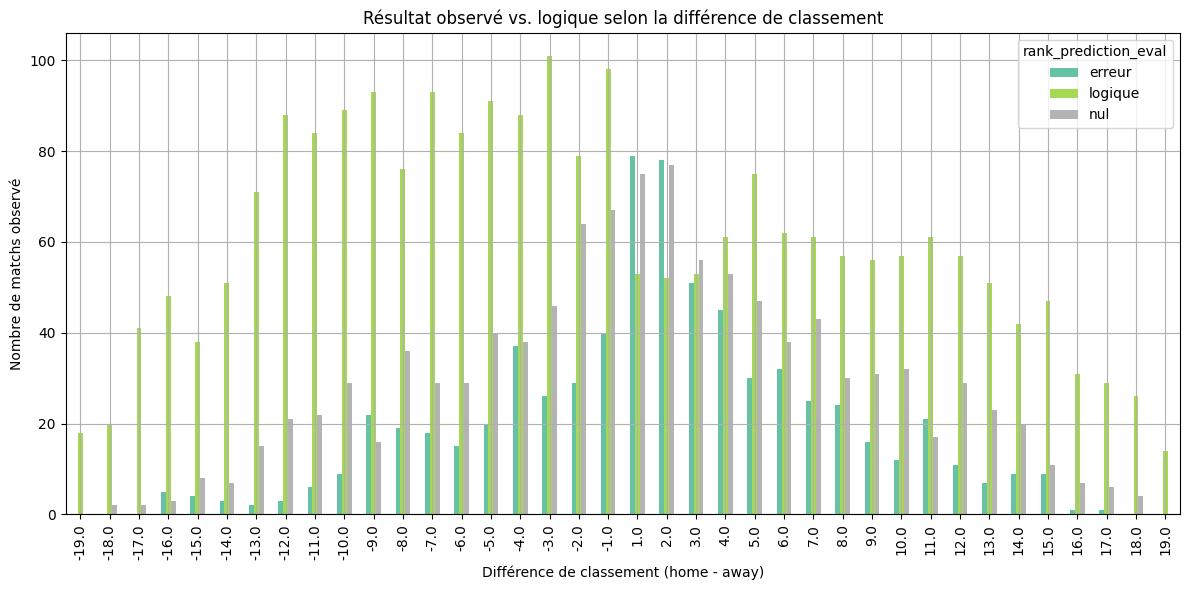

In [105]:
df_all_matches["rank_diff"]=df_all_matches["home_club_position"]-df_all_matches["away_club_position"]

def resultat_vs_rank(row):
    if row["rank_diff"] < 0:
        return "logique" if row["results"] == 1 else "erreur" if row["results"] == -1 else "nul"
    elif row["rank_diff"] > 0:
        return "logique" if row["results"] == -1 else "erreur" if row["results"] == 1 else "nul"
    else:
        return "nul"

df_all_matches["rank_prediction_eval"] = df_all_matches.apply(resultat_vs_rank, axis=1)


plot_data = df_all_matches.groupby(["rank_diff", "rank_prediction_eval"]).size().unstack(fill_value=0)

plot_data.plot(kind="bar", stacked=False, figsize=(12, 6), colormap="Set2")
plt.title("Résultat observé vs. logique selon la différence de classement")
plt.xlabel("Différence de classement (home - away)")
plt.ylabel("Nombre de matchs observé")
plt.grid(True)
plt.tight_layout()
plt.show()


### Enrichissement du dataframe général pour avoir la forme de chaque équipe sur les 5 derniers matchs

In [114]:
#%%     last_5_matchs à domicile
nb_jours_rolling=5

# On traite d'abord les matchs à domicile
home = df_all_matches[["home_club_id", "season", "date", "results"]].copy()
home = home.sort_values(by=["home_club_id", "season", "date"])
home["points"] = home["results"].map({1: 3, 0: 1, -1: 0})  # si tu utilises 2 au lieu de -1 pour défaites
home["home_streak_points"] = home.groupby("home_club_id")["points"].rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True)
home["home_streak_results"] = home.groupby("home_club_id")["results"].rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True)

df_all_matches.drop(columns=["home_streak_points", "home_streak_results"], errors="ignore", inplace=True)
df_all_matches = df_all_matches.merge(
    home[["home_club_id", "season", "date", "home_streak_points", "home_streak_results"]],
    how="left",
    left_on=["home_club_id", "season", "date"],
    right_on=["home_club_id", "season", "date"]
)
#%%     last_5_matchs à l'extèrieur

away = df_all_matches[["away_club_id", "season", "date", "results"]].copy()
away = away.sort_values(by=["away_club_id", "season", "date"])
away["points"] = away["results"].map({1: 0, 0: 1, -1: 3})  # Inversé pour l'extérieur
away["away_streak_points"] = away.groupby("away_club_id")["points"].rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True)
away["away_streak_results"] = away.groupby("away_club_id")["results"].rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True)

df_all_matches.drop(columns=["away_streak_points", "away_streak_results"], errors="ignore", inplace=True)
df_all_matches = df_all_matches.merge(
    away[["away_club_id", "season", "date", "away_streak_points", "away_streak_results"]],
    how="left",
    left_on=["away_club_id", "season", "date"],
    right_on=["away_club_id", "season", "date"]
)



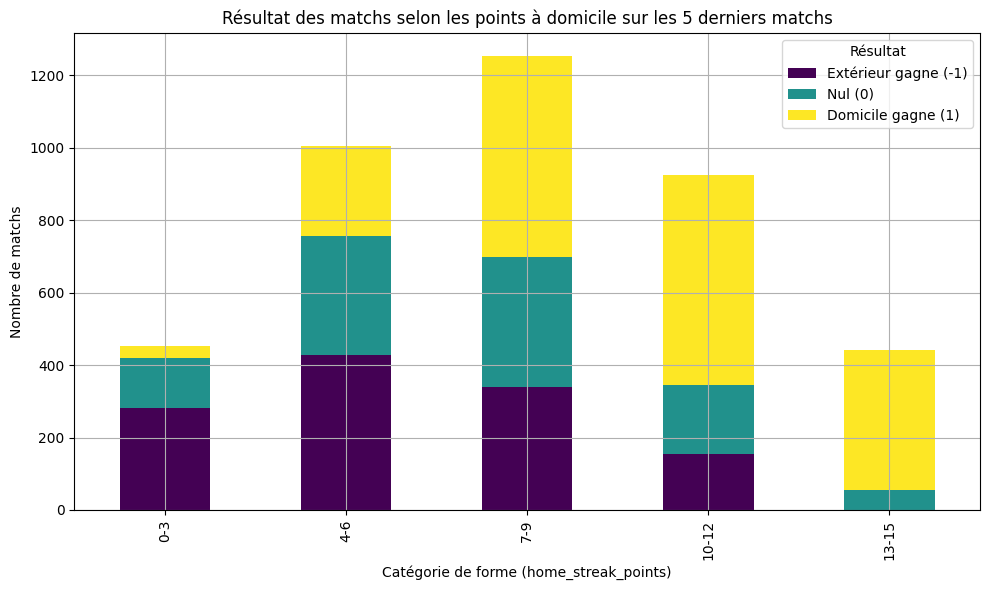

In [128]:
# Buckétiser les points à domicile
df_all_matches["home_streak_cat"] = pd.cut(
    df_all_matches["home_streak_points"],
    bins=[-1, 3, 6, 9, 12, 15],
    labels=["0-3", "4-6", "7-9", "10-12", "13-15"]
)

# Grouper les résultats par catégorie
home_streak_analysis = df_all_matches.groupby(["home_streak_cat", "results"], observed=False).size().unstack(fill_value=0)

# Tracer
home_streak_analysis.plot(kind="bar", stacked=True, colormap="viridis", figsize=(10, 6))
plt.title("Résultat des matchs selon les points à domicile sur les 5 derniers matchs")
plt.xlabel("Catégorie de forme (home_streak_points)")
plt.ylabel("Nombre de matchs")
plt.legend(title="Résultat", labels=["Extérieur gagne (-1)", "Nul (0)", "Domicile gagne (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()


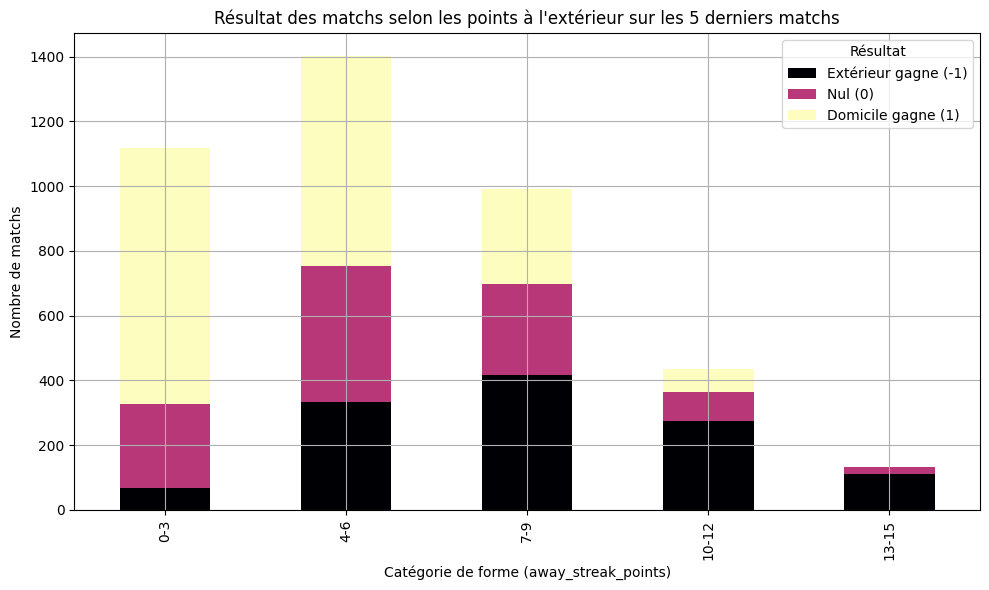

In [126]:
df_all_matches["away_streak_cat"] = pd.cut(
    df_all_matches["away_streak_points"],
    bins=[-1, 3, 6, 9, 12, 15],
    labels=["0-3", "4-6", "7-9", "10-12", "13-15"]
)
away_streak_analysis = df_all_matches.groupby(["away_streak_cat", "results"], observed=False).size().unstack(fill_value=0)

away_streak_analysis.plot(kind="bar", stacked=True, colormap="magma", figsize=(10, 6))
plt.title("Résultat des matchs selon les points à l'extérieur sur les 5 derniers matchs")
plt.xlabel("Catégorie de forme (away_streak_points)")
plt.ylabel("Nombre de matchs")
plt.legend(title="Résultat", labels=["Extérieur gagne (-1)", "Nul (0)", "Domicile gagne (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()
